## 1. Introduction
Recommender Sytem pada dasarnya adalah sistem/model/algoritma yang dimaksudkan untuk memberikan saran item yang relevan kepada pengguna. Saran tersebut bisa berupa film, musik, dan masih banyak lagi. Secara umum, jika menyangkut hubungan antara pengguna dan penyedia layanan atau pembeli dan e-commerce, rekomendasi akan sangat dibutuhkan. Pada akhirnya, rekomendasi yang layak akan menjadi win-win solution yang menguntungkan kedua belah pihak karena pengguna lebih royal karena mendapatkan apa yang mereka inginkan dan penyedia layanan memperoleh keuntungan lebih.

## 1. Data Preview dan Preprocessing

In [1]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs
from collections import Counter
from typing import Dict, Text
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [2]:
credits = pd.read_csv(r'C:\\Users\\PPL2\\Documents\\Private\\Model\\Pacman Data Science\\Project\\Recommender System/credits.csv')
keywords = pd.read_csv(r'C:\\Users\\PPL2\\Documents\\Private\\Model\\Pacman Data Science\\Project\\Recommender System/keywords.csv')
movies = pd.read_csv(r'C:\\Users\\PPL2\\Documents\\Private\\Model\\Pacman Data Science\\Project\\Recommender System/movies_metadata.csv').\
                     drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).\
                     drop([19730, 29503, 35587]) # Incorrect data type

movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id').\
    merge(credits, on='id')

df['original_language'] = df['original_language'].fillna('')
df['runtime'] = df['runtime'].fillna(0)
df['tagline'] = df['tagline'].fillna('')

df.dropna(inplace=True)

In [3]:
def get_text(text, obj='name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)
    
df['genres'] = df['genres'].apply(get_text)
df['production_companies'] = df['production_companies'].apply(get_text)
df['production_countries'] = df['production_countries'].apply(get_text)
df['crew'] = df['crew'].apply(get_text)
df['spoken_languages'] = df['spoken_languages'].apply(get_text)
df['keywords'] = df['keywords'].apply(get_text)

# New columns
df['characters'] = df['cast'].apply(get_text, obj='character')
df['actors'] = df['cast'].apply(get_text)

df.drop('cast', axis=1, inplace=True)
df = df[~df['original_title'].duplicated()]
df = df.reset_index(drop=True)

In [4]:
# Cleaned dataset
df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,...,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,crew,characters,actors
0,False,30000000,"Animation, Comedy, Family",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,Pixar Animation Studios,United States of America,...,373554033.0,81.0,English,,7.7,5415.0,"jealousy, toy, boy, friendship, friends, rival...","John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,..."
1,False,65000000,"Adventure, Fantasy, Family",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,...,262797249.0,104.0,"English, Français",Roll the dice and unleash the excitement!,6.9,2413.0,"board game, disappearance, based on children's...","Larry J. Franco, Jonathan Hensleigh, James Hor...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ..."
2,False,0,"Romance, Comedy",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"Warner Bros., Lancaster Gate",United States of America,...,0.0,101.0,English,Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"fishing, best friend, duringcreditsstinger, ol...","Howard Deutch, Mark Steven Johnson, Mark Steve...","Max Goldman, John Gustafson, Ariel Gustafson, ...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph..."
3,False,16000000,"Comedy, Drama, Romance",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,Twentieth Century Fox Film Corporation,United States of America,...,81452156.0,127.0,English,Friends are the people who let you be yourself...,6.1,34.0,"based on novel, interracial relationship, sing...","Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...","Whitney Houston, Angela Bassett, Loretta Devin..."
4,False,0,Comedy,11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"Sandollar Productions, Touchstone Pictures",United States of America,...,76578911.0,106.0,English,Just When His World Is Back To Normal... He's ...,5.7,173.0,"baby, midlife crisis, confidence, aging, daugh...","Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","George Banks, Nina Banks, Franck Eggelhoffer, ...","Steve Martin, Diane Keaton, Martin Short, Kimb..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42373 entries, 0 to 42372
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 42373 non-null  object 
 1   budget                42373 non-null  object 
 2   genres                42373 non-null  object 
 3   id                    42373 non-null  int64  
 4   original_language     42373 non-null  object 
 5   original_title        42373 non-null  object 
 6   overview              42373 non-null  object 
 7   popularity            42373 non-null  object 
 8   production_companies  42373 non-null  object 
 9   production_countries  42373 non-null  object 
 10  release_date          42373 non-null  object 
 11  revenue               42373 non-null  float64
 12  runtime               42373 non-null  float64
 13  spoken_languages      42373 non-null  object 
 14  tagline               42373 non-null  object 
 15  vote_average       

In [6]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['budget'] = df['budget'].astype('float64')
df['popularity'] = df['popularity'].astype('float64')

## 2. Exploratory Data Analysis

(0.0, 2.0, 0.9, 1.2)

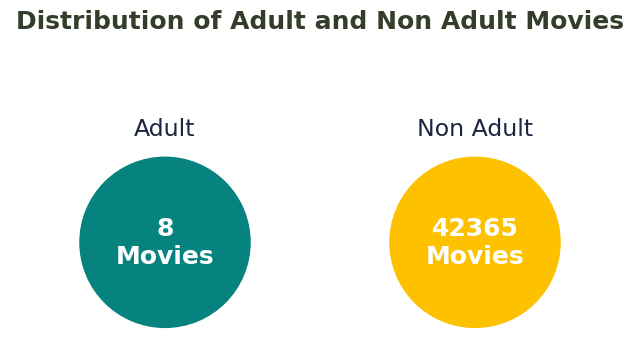

In [7]:
plt.figure(figsize=(8,4))
plt.scatter(x=[0.5, 1.5], y=[1,1], s=15000, color=['#06837f', '#fdc100'])
plt.xlim(0,2)
plt.ylim(0.9,1.2)

plt.title('Distribution of Adult and Non Adult Movies', fontsize=18, weight=600, color='#333d29')
plt.text(0.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='True']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(1.5, 1, '{}\nMovies'.format(str(len(df[df['adult']=='False']))), va='center', ha='center', fontsize=18, weight=600, color='white')
plt.text(0.5, 1.11, 'Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')
plt.text(1.5, 1.11, 'Non Adult', va='center', ha='center', fontsize=17, weight=500, color='#1c2541')

plt.axis('off')

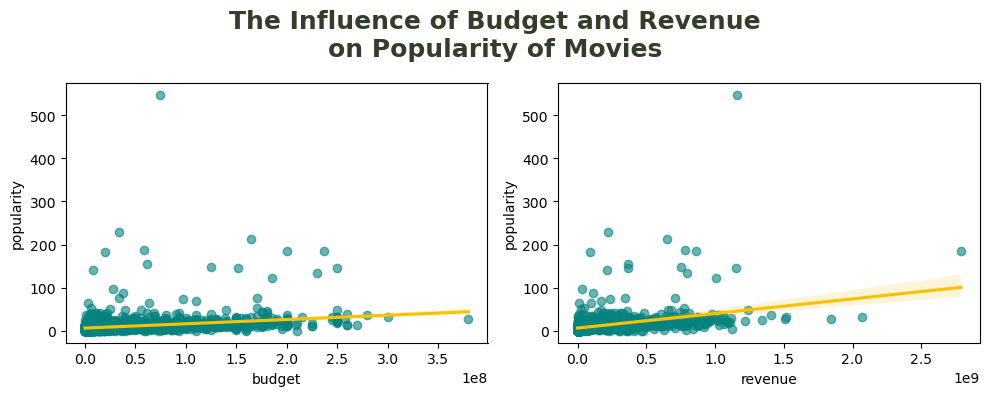

In [8]:
df_plot = df[(df['budget'] != 0) & (df['revenue'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.suptitle('The Influence of Budget and Revenue\non Popularity of Movies', fontsize=18, weight=600, color='#333d29')
for i, col in enumerate(['budget', 'revenue']):
    sns.regplot(data=df_plot, x=col, y='popularity',
                scatter_kws={"color": "#06837f", "alpha": 0.6}, line_kws={"color": "#fdc100"}, ax=axes[i])

plt.tight_layout()

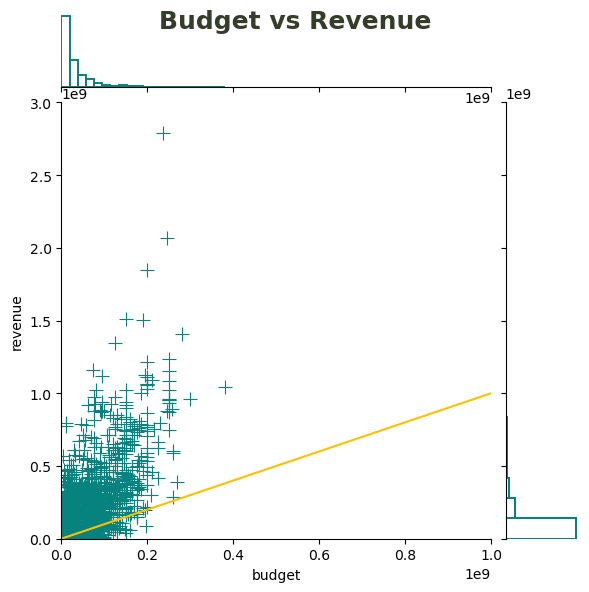

In [9]:
ax = sns.jointplot(data=df[(df['budget'] != 0) & (df['revenue'] != 0)], x='budget', y='revenue',
                   marker="+", s=100, marginal_kws=dict(bins=20, fill=False), color='#06837f')
ax.fig.suptitle('Budget vs Revenue', fontsize=18, weight=600, color='#333d29')
ax.ax_joint.set_xlim(0, 1e9)
ax.ax_joint.set_ylim(0, 3e9)
ax.ax_joint.axline((1,1), slope=1, color='#fdc100')

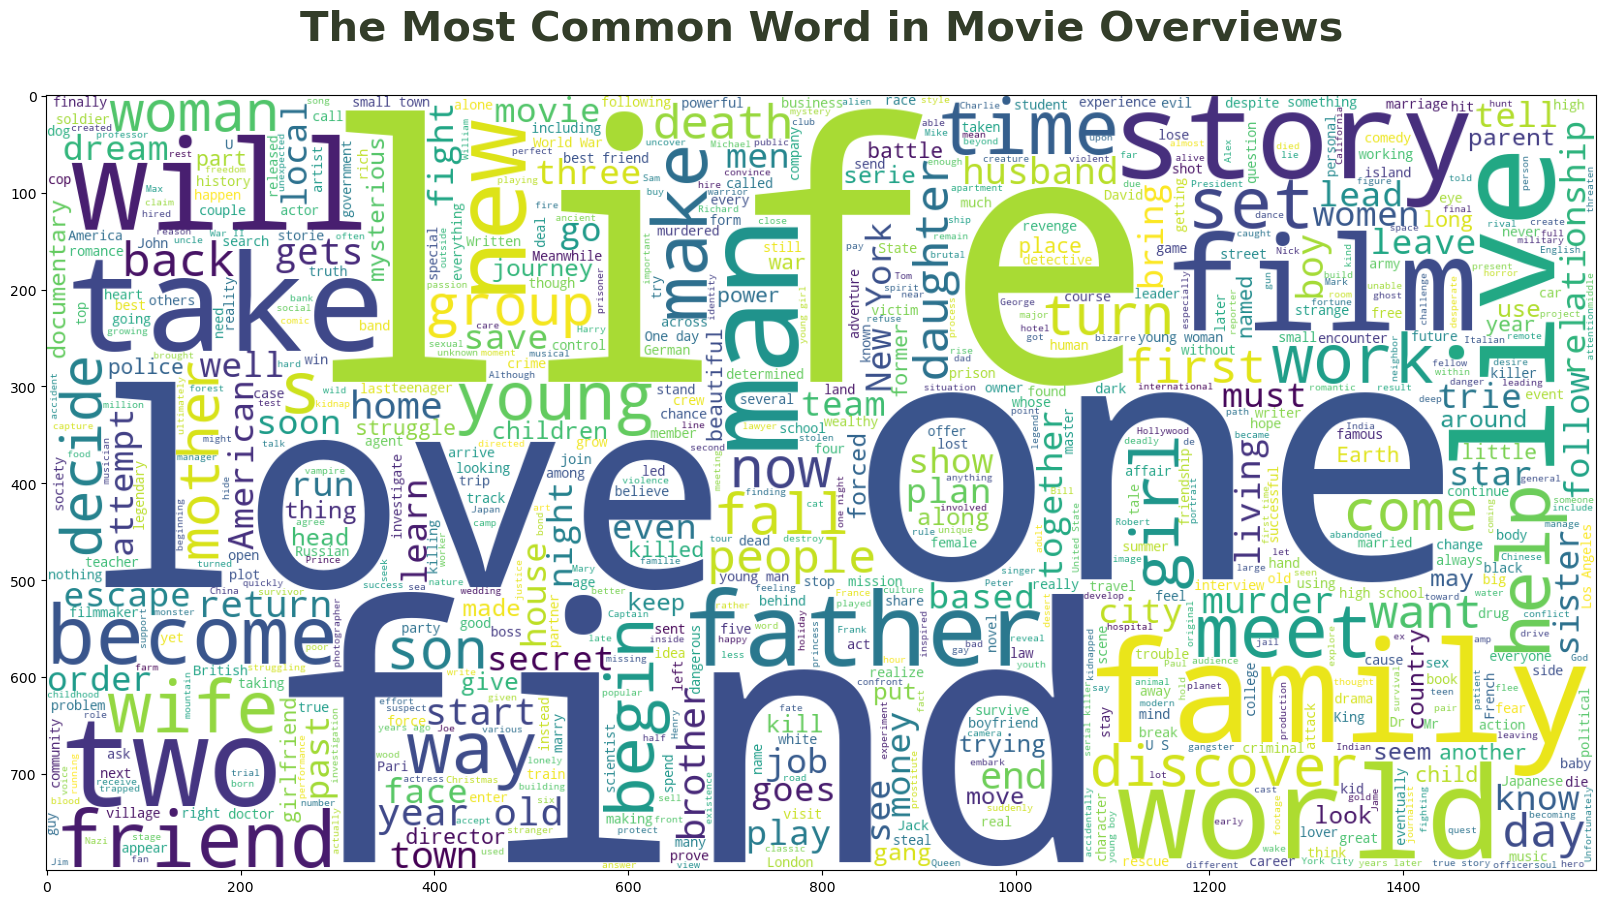

In [10]:
plt.figure(figsize=(20,20))
plt.title('The Most Common Word in Movie Overviews\n', fontsize=30, weight=600, color='#333d29')
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white").generate(' '.join(df['overview']))

plt.imshow(wc)

(-1.25, 1.25, -1.25, 1.25)

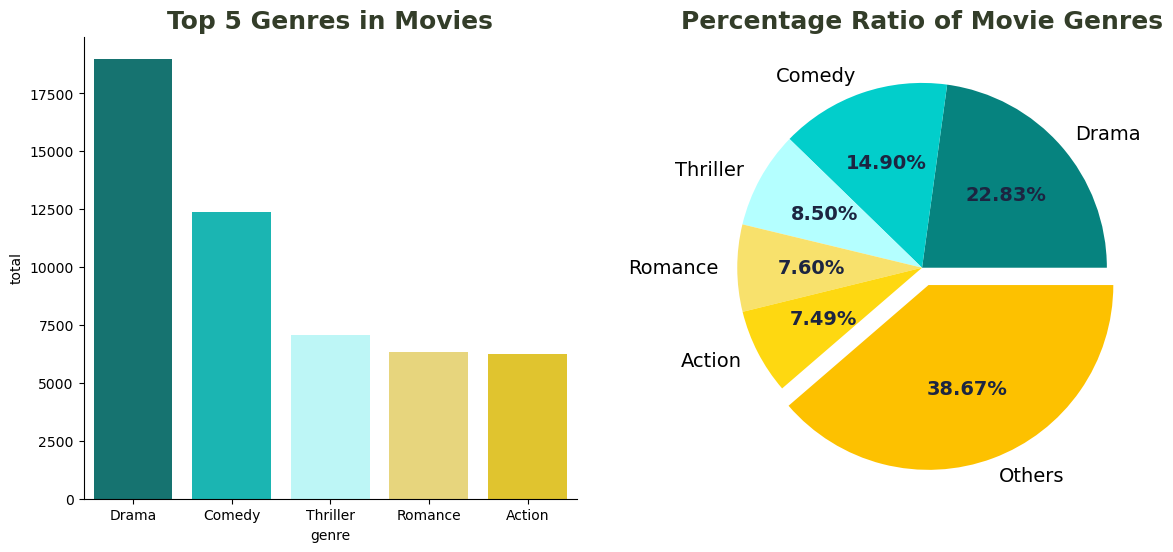

In [11]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i.split(', '))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')
wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), explode=[0,0,0,0,0,0.1], colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

Text(0.5, 1.0, 'Total Released Movie by Date')

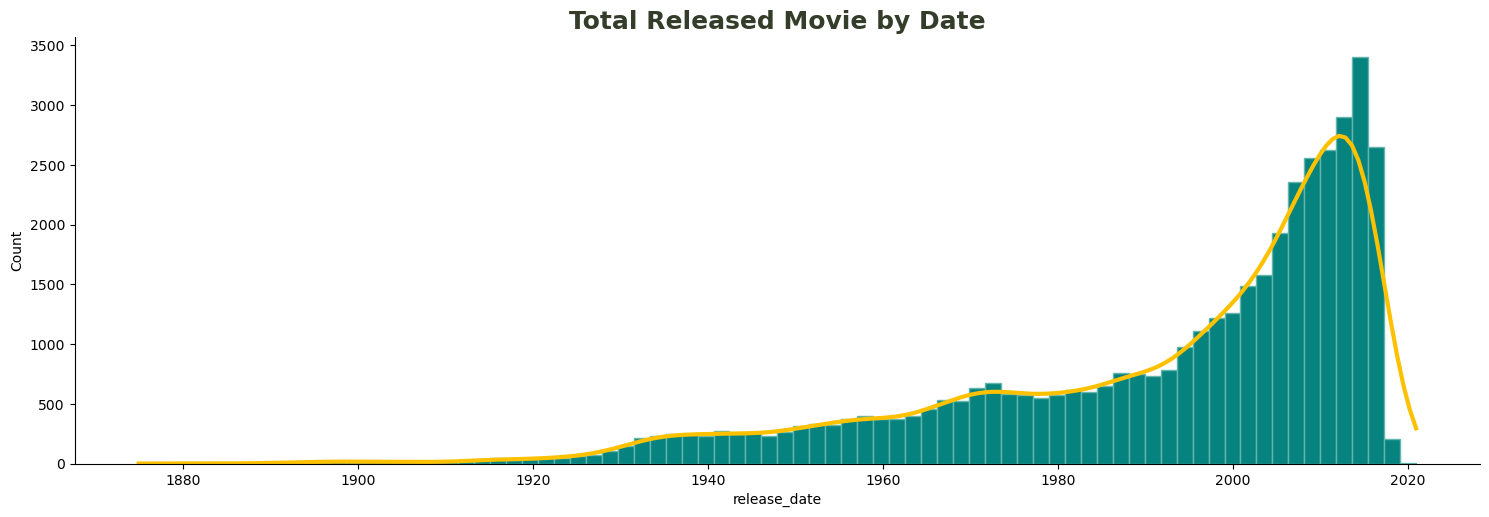

In [12]:
sns.displot(data=df, x='release_date', kind='hist', kde=True,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)
plt.title('Total Released Movie by Date', fontsize=18, weight=600, color='#333d29')

In [13]:
original_language_list = []
for i in df['original_language']:
    original_language_list.extend(i.split(', '))
    
spoken_languages_list = []
for i in df['spoken_languages']:
    if i != '':
        spoken_languages_list.extend(i.split(', '))

actors_list = []
for i in df['actors']:
    if i != '':
        actors_list.extend(i.split(', '))
        
crew_list = []
for i in df['crew']:
    if i != '':
        crew_list.extend(i.split(', '))

company_list = []
for i in df['production_companies']:
    if i != '':
        company_list.extend(i.split(', '))
    
country_list = []
for i in df['production_countries']:
    if i != '':
        country_list.extend(i.split(', '))

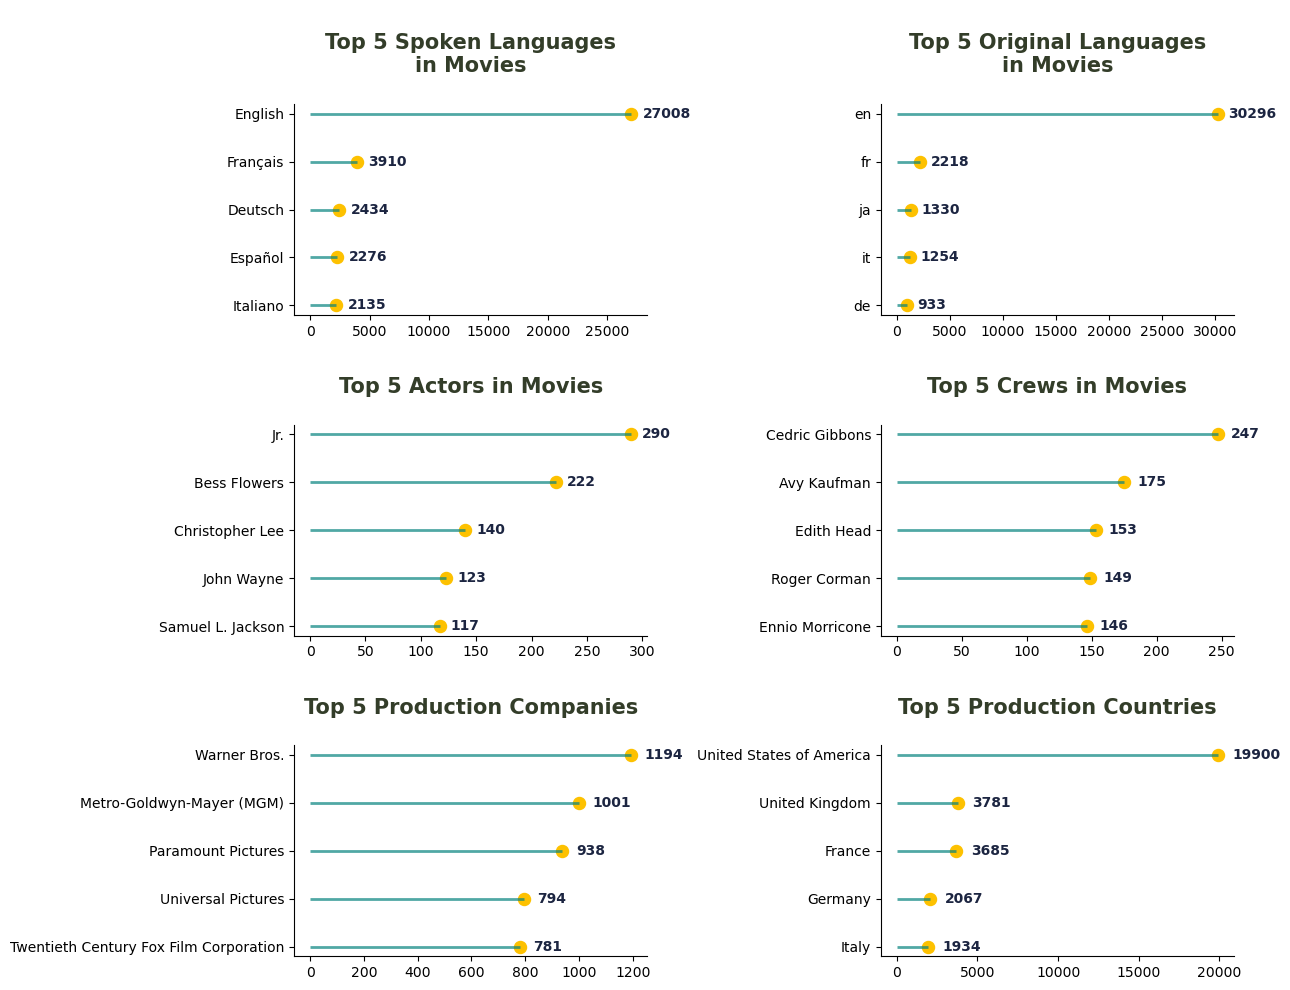

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 10))

# Spoken language plot
df_plot1 = pd.DataFrame(Counter(spoken_languages_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,0].hlines(y=df_plot1['language'], xmin=0, xmax=df_plot1['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,0].scatter(x=df_plot1['total'], y=df_plot1['language'], s = 75, color='#fdc100')
axes[0,0].set_title('\nTop 5 Spoken Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot1['total']):
    axes[0,0].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Original Language plot
df_plot2 = pd.DataFrame(Counter(original_language_list).most_common(5), columns=['language', 'total']).sort_values(by='total', ascending=True)
axes[0,1].hlines(y=df_plot2['language'], xmin=0, xmax=df_plot2['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[0,1].scatter(x=df_plot2['total'], y=df_plot2['language'], s = 75, color='#fdc100')
axes[0,1].set_title('\nTop 5 Original Languages\nin Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot2['total']):
    axes[0,1].text(value+1000, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Actor plot
df_plot3 = pd.DataFrame(Counter(actors_list).most_common(5), columns=['actor', 'total']).sort_values(by='total', ascending=True)
axes[1,0].hlines(y=df_plot3['actor'], xmin=0, xmax=df_plot3['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,0].scatter(x=df_plot3['total'], y=df_plot3['actor'], s = 75, color='#fdc100')
axes[1,0].set_title('\nTop 5 Actors in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot3['total']):
    axes[1,0].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Crew plot
df_plot4 = pd.DataFrame(Counter(crew_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[1,1].hlines(y=df_plot4['name'], xmin=0, xmax=df_plot4['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[1,1].scatter(x=df_plot4['total'], y=df_plot4['name'], s = 75, color='#fdc100')
axes[1,1].set_title('\nTop 5 Crews in Movies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot4['total']):
    axes[1,1].text(value+10, i, value, va='center', fontsize=10, weight=600, color='#1c2541')

# Company plot
df_plot5 = pd.DataFrame(Counter(company_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,0].hlines(y=df_plot5['name'], xmin=0, xmax=df_plot5['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,0].scatter(x=df_plot5['total'], y=df_plot5['name'], s = 75, color='#fdc100')
axes[2,0].set_title('\nTop 5 Production Companies\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot5['total']):
    axes[2,0].text(value+50, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
# Country plot
df_plot6 = pd.DataFrame(Counter(country_list).most_common(5), columns=['name', 'total']).sort_values(by='total', ascending=True)
axes[2,1].hlines(y=df_plot6['name'], xmin=0, xmax=df_plot6['total'], color= '#06837f', alpha=0.7, linewidth=2)
axes[2,1].scatter(x=df_plot6['total'], y=df_plot6['name'], s = 75, color='#fdc100')
axes[2,1].set_title('\nTop 5 Production Countries\n', fontsize=15, weight=600, color='#333d29')
for i, value in enumerate(df_plot6['total']):
    axes[2,1].text(value+900, i, value, va='center', fontsize=10, weight=600, color='#1c2541')
    
sns.despine()
plt.tight_layout()

Text(0.5, 1.0, 'The Relationship Between Rating and Popularity')

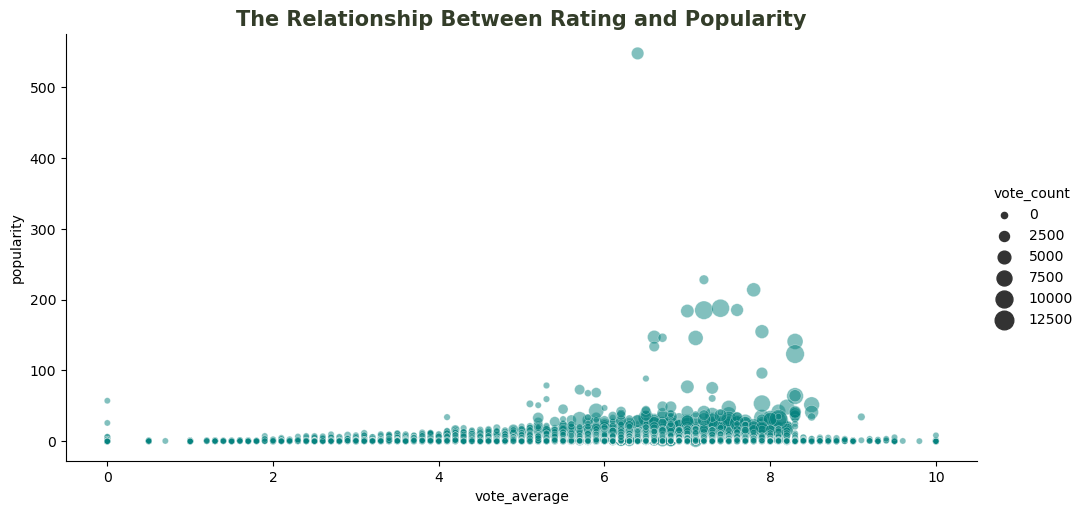

In [15]:
sns.relplot(data=df, x='vote_average', y='popularity', size='vote_count',
            sizes=(20, 200), alpha=.5, aspect=2, color='#06837f')
plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')

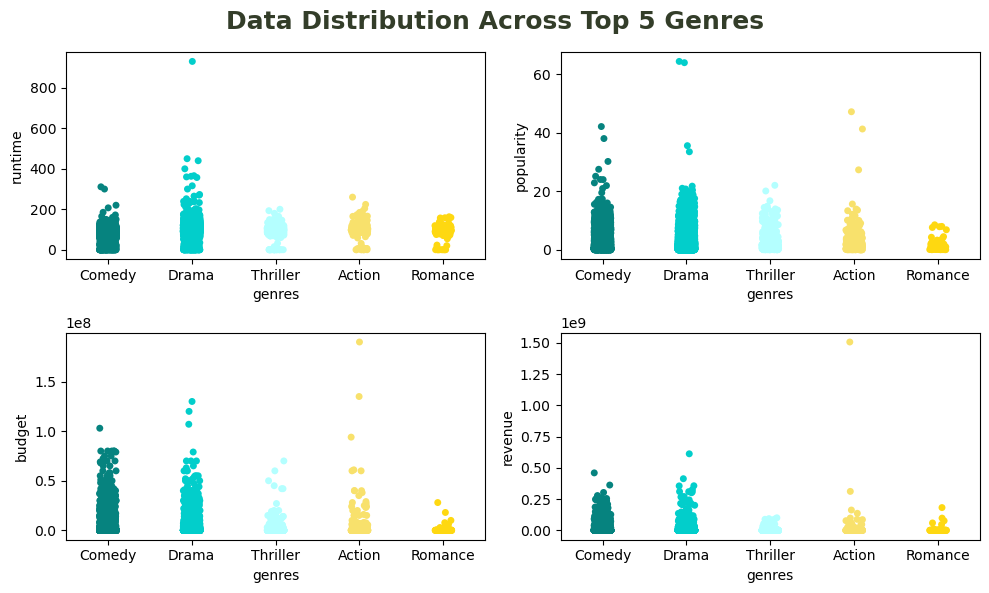

In [16]:
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
df_plot = df[df['genres'].isin(df_plot['genre'].to_numpy())]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6))

plt.suptitle('Data Distribution Across Top 5 Genres', fontsize=18, weight=600, color='#333d29')
for i, y in enumerate(['runtime', 'popularity', 'budget', 'revenue']):
    sns.stripplot(data=df_plot, x='genres', y=y, ax=axes.flatten()[i], palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

plt.tight_layout()

In [17]:
#plt.figure(figsize=(12,10))
#plt.title('Correlation of Movie Features\n', fontsize=18, weight=600, color='#333d29')
#sns.heatmap(df.corr(), annot=True, cmap=['#004346', '#036666', '#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100']).astype(float)

## 3. Content Base Recommender

Ide dibalik recommender tipe ini :

1. Film yang lebih populer memiliki kesempatan untuk disukai oleh rata-rata pengguna
2. Model ini tidak memberikan rekomendasi personal untuk setiap tipe pengguna

Penerapan model ini adalah dengan menyortir film sesuai rating dan popularitas dan menunjukkan film teratas dari daftar film. Orang menonton film bukan hanya karena melihat rating yang baik dari suatu filem, tapi juga dampak hype atau ketenaran dari suatu film, sehingga popularitas perlu untuk dimasukkan ke dalam pertimbangan, Secara arbitrary untuk project ini penulis memilih bobot 40% untuk weighted average dan 60% untuk popularitas dengna pertimbangan bahwa kecenderungan orang untuk tidak ingin melewatkan filem yang sedang viral walaupun review ataupun ratingnya buruk.


In [18]:
R = df['vote_average']
v = df['vote_count']
# We will only consider movies that have more votes than at least 80% of the movies in our dataset
m = df['vote_count'].quantile(0.8)
C = df['vote_average'].mean()

df['weighted_average'] = (R*v + C*m)/(v+m)

In [19]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['popularity', 'weighted_average']])
weighted_df = pd.DataFrame(scaled, columns=['popularity', 'weighted_average'])

weighted_df.index = df['original_title']

In [20]:
weighted_df['score'] = weighted_df['weighted_average']*0.4 + weighted_df['popularity'].astype('float64')*0.6

In [21]:
weighted_df_sorted = weighted_df.sort_values(by='score', ascending=False)
weighted_df_sorted.head(10)

,popularity,weighted_average,score
original_title,,,
Minions,1.000000,0.603532,0.841413
Big Hero 6,0.390602,0.827561,0.565386
Baby Driver,0.416507,0.727736,0.540998
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054
Pulp Fiction,0.257449,0.908395,0.517827
Deadpool,0.343132,0.764657,0.511742
Gone Girl,0.282748,0.843413,0.507014
The Dark Knight,0.224968,0.909123,0.498630
Avatar,0.338036,0.732643,0.495879


In [22]:
content_df = df[['original_title', 'adult', 'genres', 'overview', 'production_companies', 'tagline', 'keywords', 'crew', 'characters', 'actors']]

In [23]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) # Remove text inside parentheses
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text

In [24]:
content_df['adult'] = content_df['adult'].apply(remove_punc)
content_df['genres'] = content_df['genres'].apply(remove_punc)
content_df['overview'] = content_df['overview'].apply(remove_punc)
content_df['production_companies'] = content_df['production_companies'].apply(separate)
content_df['tagline'] = content_df['tagline'].apply(remove_punc)
content_df['keywords'] = content_df['keywords'].apply(separate)
content_df['crew'] = content_df['crew'].apply(separate)
content_df['characters'] = content_df['characters'].apply(separate)
content_df['actors'] = content_df['actors'].apply(separate)

content_df['bag_of_words'] = ''
content_df['bag_of_words'] = content_df[content_df.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
content_df.set_index('original_title', inplace=True)

content_df = content_df[['bag_of_words']]
content_df.head()

,bag_of_words
original_title,
Toy Story,false animation comedy family led by woody and...
Jumanji,false adventure fantasy family when siblings j...
Grumpier Old Men,false romance comedy a family wedding reignite...
Waiting to Exhale,false comedy drama romance cheated on mistreat...
Father of the Bride Part II,false comedy just when george banks has recove...


In [25]:
content_df = weighted_df_sorted[:10000].merge(content_df, left_index=True, right_index=True, how='left')

tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tfidf_matrix = tfidf.fit_transform(content_df['bag_of_words'])
tfidf_matrix.shape

(10000, 28645)

In [26]:
cos_sim = cosine_similarity(tfidf_matrix)
cos_sim.shape

(10000, 10000)

In [27]:
content_df.head()

,popularity,weighted_average,score,bag_of_words
original_title,,,,
Minions,1.000000,0.603532,0.841413,false family animation adventure comedy minion...
Big Hero 6,0.390602,0.827561,0.565386,false adventure family animation action comedy...
Baby Driver,0.416507,0.727736,0.540998,false action crime after being coerced into wo...
Guardians of the Galaxy Vol. 2,0.338511,0.794867,0.521054,false action adventure comedy science fiction ...
Pulp Fiction,0.257449,0.908395,0.517827,false thriller crime a burgerloving hit man hi...


In [28]:
def predict(title, similarity_weight=0.7, top_n=10):
    data = content_df.reset_index()
    index_movie = data[data['original_title'] == title].index
    similarity = cos_sim[index_movie].T
    
    sim_df = pd.DataFrame(similarity, columns=['similarity'])
    final_df = pd.concat([data, sim_df], axis=1)
    # You can also play around with the number
    final_df['final_score'] = final_df['score']*(1-similarity_weight) + final_df['similarity']*similarity_weight
    
    final_df_sorted = final_df.sort_values(by='final_score', ascending=False).head(top_n)
    final_df_sorted.set_index('original_title', inplace=True)
    return final_df_sorted[['score', 'similarity', 'final_score']]

In [29]:
predict('Toy Story', similarity_weight=0.7, top_n=10)

,score,similarity,final_score
original_title,,,
Toy Story,0.348515,1.000000,0.804555
Toy Story 2,0.317785,0.537320,0.471460
Toy Story 3,0.336500,0.274778,0.293295
Toy Story of Terror!,0.282269,0.294860,0.291082
Small Fry,0.256223,0.271028,0.266586
Hawaiian Vacation,0.266277,0.263819,0.264556
Minions,0.841413,0.005376,0.256187
Finding Nemo,0.346185,0.203631,0.246397
WALL·E,0.348682,0.196733,0.242317


In [30]:
ratings_df = pd.read_csv(r'C:\\Users\\PPL2\\Documents\\Private\\Model\\Pacman Data Science\\Project\\Recommender System/ratings_small.csv')

ratings_df['date'] = ratings_df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings_df.drop('timestamp', axis=1, inplace=True)

ratings_df = ratings_df.merge(df[['id', 'original_title', 'genres', 'overview']], left_on='movieId',right_on='id', how='left')
ratings_df = ratings_df[~ratings_df['id'].isna()]
ratings_df.drop('id', axis=1, inplace=True)
ratings_df.reset_index(drop=True, inplace=True)

ratings_df.head()

,userId,movieId,rating,date,original_title,genres,overview
0,1,1371,2.5,2009-12-14 09:52:15,Rocky III,Drama,"Now the world champion, Rocky Balboa is living..."
1,1,1405,1.0,2009-12-14 09:53:23,Greed,"Drama, History",Greed is the classic 1924 silent film by Erich...
2,1,2105,4.0,2009-12-14 09:52:19,American Pie,"Comedy, Romance","At a high-school party, four friends find that..."
3,1,2193,2.0,2009-12-14 09:53:18,My Tutor,"Comedy, Drama, Romance",High school senior Bobby Chrystal fails his Fr...
4,1,2294,2.0,2009-12-14 09:51:48,Jay and Silent Bob Strike Back,Comedy,When Jay and Silent Bob learn that their comic...


In [31]:
movies_df = df[['id', 'original_title']]
movies_df.rename(columns={'id':'movieId'}, inplace=True)
movies_df.head()

,movieId,original_title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [32]:
ratings_df['userId'] = ratings_df['userId'].astype(str)

ratings = tf.data.Dataset.from_tensor_slices(dict(ratings_df[['userId', 'original_title', 'rating']]))
movies = tf.data.Dataset.from_tensor_slices(dict(movies_df[['original_title']]))

ratings = ratings.map(lambda x: {
    "original_title": x["original_title"],
    "userId": x["userId"],
    "rating": float(x["rating"])
})

movies = movies.map(lambda x: x["original_title"])

In [33]:
print('Total Data: {}'.format(len(ratings)))

tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = ratings.take(35_000)
test = ratings.skip(35_000).take(8_188)

Total Data: 43188


In [34]:
movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000).map(lambda x: x["userId"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

print('Unique Movies: {}'.format(len(unique_movie_titles)))
print('Unique users: {}'.format(len(unique_user_ids)))

Unique Movies: 42373
Unique users: 671


## 4. Deep Learning Base Recommender

In [35]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [88]:
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userId"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["original_title"])
    
    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

## Multi Task Model

Ada dua part dari multi-task recommenders:

1. Optimasi 1 atau 2 obyektif dengan 2 atau lebih losses
2. Share variabel antar task dengan transfer learning

Dalam project ini ada 2 task yang dikerjakan recommender yaitu memprediksi rating dan memprediksi film yang ditonton. Namun sebelum melakukan multi task kita akan mencoba untuk single task secara berturut-turut yaitu prediksi rating dan prediksi film sebelum digabungkan dalam multi task



In [130]:
''' Single Task Prediksi Rating, Rating Weight dibobot 1 dan retrieval weight dibobot 0'''
model = MovieModel(rating_weight=1.0, retrieval_weight=0.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

model.fit(cached_train, epochs=3)

Epoch 1/3
5/5 [==============================] - 82s 15s/step - root_mean_squared_error: 2.7962 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 2.5714e-04 - factorized_top_k/top_10_categorical_accuracy: 3.4286e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0016 - factorized_top_k/top_100_categorical_accuracy: 0.0027 - loss: 6.5087 - regularization_loss: 0.0000e+00 - total_loss: 6.5087
Epoch 2/3
5/5 [==============================] - 76s 15s/step - root_mean_squared_error: 1.0865 - factorized_top_k/top_1_categorical_accuracy: 2.8571e-05 - factorized_top_k/top_5_categorical_accuracy: 2.0000e-04 - factorized_top_k/top_10_categorical_accuracy: 3.4286e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0017 - factorized_top_k/top_100_categorical_accuracy: 0.0028 - loss: 1.1678 - regularization_loss: 0.0000e+00 - total_loss: 1.1678
Epoch 3/3
5/5 [==============================] - 78s 15s/step - root_mean_squared_error: 1.0902 

In [131]:
metrics = model.evaluate(cached_train, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

5/5 [==============================] - 74s 14s/step - root_mean_squared_error: 1.0798 - factorized_top_k/top_1_categorical_accuracy: 5.7143e-05 - factorized_top_k/top_5_categorical_accuracy: 2.2857e-04 - factorized_top_k/top_10_categorical_accuracy: 3.4286e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0017 - factorized_top_k/top_100_categorical_accuracy: 0.0028 - loss: 1.1545 - regularization_loss: 0.0000e+00 - total_loss: 1.1545

Retrieval top-100 accuracy: 0.003
Ranking RMSE: 1.080


In [132]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

2/2 [==============================] - 14s 6s/step - root_mean_squared_error: 1.0335 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 1.2213e-04 - factorized_top_k/top_10_categorical_accuracy: 2.4426e-04 - factorized_top_k/top_50_categorical_accuracy: 7.3278e-04 - factorized_top_k/top_100_categorical_accuracy: 0.0015 - loss: 1.0703 - regularization_loss: 0.0000e+00 - total_loss: 1.0703

Retrieval top-100 accuracy: 0.001
Ranking RMSE: 1.034


In [95]:
# Get meta data for predicted movie
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# Get recommendations.
_, titles = index(tf.constant(['123']))
pred_movies = pd.DataFrame({'original_title': [i.decode('utf-8') for i in titles[0,:5].numpy()]})

pred_df = pred_movies.merge(ratings_df[['original_title', 'genres', 'overview']], on='original_title', how='left')
pred_df = pred_df[~pred_df['original_title'].duplicated()]
pred_df.reset_index(drop=True, inplace=True)
pred_df.index = np.arange(1, len(pred_df)+1)

pred_df

,original_title,genres,overview
1,The Bourne Supremacy,"Action, Drama, Thriller",When a CIA operation to purchase classified Ru...
2,Un long dimanche de fiançailles,Drama,"In 1919, Mathilde was 19 years old. Two years ..."
3,Scary Movie,Comedy,Following on the heels of popular teen-scream ...
4,The Greatest Story Ever Told,"Drama, History",All-star epic retelling of Christ's life.
5,Dog Day Afternoon,"Crime, Drama, Thriller",A man robs a bank to pay for his lover's opera...


In [139]:
''' Single Task Prediksi Rating, Rating Weight dibobot 0 dan retrieval weight dibobot 1'''
model = MovieModel(rating_weight=0.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()


model.fit(cached_train, epochs=3)

Epoch 1/3
5/5 [==============================] - 29s 5s/step - root_mean_squared_error: 3.7269 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 4.2857e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0016 - factorized_top_k/top_50_categorical_accuracy: 0.0319 - factorized_top_k/top_100_categorical_accuracy: 0.0639 - loss: 54826.5007 - regularization_loss: 0.0000e+00 - total_loss: 54826.5007
Epoch 2/3
5/5 [==============================] - 28s 5s/step - root_mean_squared_error: 3.7716 - factorized_top_k/top_1_categorical_accuracy: 9.7143e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0111 - factorized_top_k/top_10_categorical_accuracy: 0.0261 - factorized_top_k/top_50_categorical_accuracy: 0.1578 - factorized_top_k/top_100_categorical_accuracy: 0.2722 - loss: 53033.8216 - regularization_loss: 0.0000e+00 - total_loss: 53033.8216
Epoch 3/3
5/5 [==============================] - 29s 6s/step - root_mean_squared_error: 3.8084

In [140]:
metrics = model.evaluate(cached_train, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

5/5 [==============================] - 27s 5s/step - root_mean_squared_error: 3.8266 - factorized_top_k/top_1_categorical_accuracy: 0.0085 - factorized_top_k/top_5_categorical_accuracy: 0.0564 - factorized_top_k/top_10_categorical_accuracy: 0.1042 - factorized_top_k/top_50_categorical_accuracy: 0.3330 - factorized_top_k/top_100_categorical_accuracy: 0.4774 - loss: 49296.9717 - regularization_loss: 0.0000e+00 - total_loss: 49296.9717

Retrieval top-100 accuracy: 0.477
Ranking RMSE: 3.827


In [141]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

2/2 [==============================] - 5s 2s/step - root_mean_squared_error: 3.8373 - factorized_top_k/top_1_categorical_accuracy: 4.8852e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0048 - factorized_top_k/top_10_categorical_accuracy: 0.0099 - factorized_top_k/top_50_categorical_accuracy: 0.0445 - factorized_top_k/top_100_categorical_accuracy: 0.0800 - loss: 34061.4010 - regularization_loss: 0.0000e+00 - total_loss: 34061.4010

Retrieval top-100 accuracy: 0.080
Ranking RMSE: 3.837


In [142]:
''' Multi Task Prediksi Rating, Rating Weight dibobot 1 dan retrieval weight dibobot 1'''
model = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

model.fit(cached_train, epochs=3)

Epoch 1/3
5/5 [==============================] - 28s 5s/step - root_mean_squared_error: 2.7134 - factorized_top_k/top_1_categorical_accuracy: 2.8571e-05 - factorized_top_k/top_5_categorical_accuracy: 4.2857e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0020 - factorized_top_k/top_50_categorical_accuracy: 0.0260 - factorized_top_k/top_100_categorical_accuracy: 0.0569 - loss: 54869.0527 - regularization_loss: 0.0000e+00 - total_loss: 54869.0527
Epoch 2/3
5/5 [==============================] - 27s 5s/step - root_mean_squared_error: 1.4964 - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0090 - factorized_top_k/top_10_categorical_accuracy: 0.0235 - factorized_top_k/top_50_categorical_accuracy: 0.1559 - factorized_top_k/top_100_categorical_accuracy: 0.2749 - loss: 53103.9609 - regularization_loss: 0.0000e+00 - total_loss: 53103.9609
Epoch 3/3
5/5 [==============================] - 27s 5s/step - root_mean_squared_error: 1.3318 - f

In [143]:
metrics = model.evaluate(cached_train, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

5/5 [==============================] - 30s 6s/step - root_mean_squared_error: 1.1942 - factorized_top_k/top_1_categorical_accuracy: 0.0084 - factorized_top_k/top_5_categorical_accuracy: 0.0554 - factorized_top_k/top_10_categorical_accuracy: 0.1030 - factorized_top_k/top_50_categorical_accuracy: 0.3313 - factorized_top_k/top_100_categorical_accuracy: 0.4779 - loss: 49285.3483 - regularization_loss: 0.0000e+00 - total_loss: 49285.3483

Retrieval top-100 accuracy: 0.478
Ranking RMSE: 1.194


In [144]:
metrics = model.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

2/2 [==============================] - 5s 3s/step - root_mean_squared_error: 0.9675 - factorized_top_k/top_1_categorical_accuracy: 7.3278e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0055 - factorized_top_k/top_10_categorical_accuracy: 0.0107 - factorized_top_k/top_50_categorical_accuracy: 0.0476 - factorized_top_k/top_100_categorical_accuracy: 0.0857 - loss: 34040.8919 - regularization_loss: 0.0000e+00 - total_loss: 34040.8919

Retrieval top-100 accuracy: 0.086
Ranking RMSE: 0.968


# Hyperparameter Tuning

Pada part ini akan dilakukan hyperparameter tuning dengan mengubah arsitektur deep learning dan pembobotan task. Arsitektur dilakukan dengan mengubah jumlah layer dan epoch. Sedangkankan perubahan pembobotan task dilakukan dengan mengubah proporsi antara rating task dan retrieval task

In [153]:
class MovieModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 64

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension),
      tf.keras.layers.Flatten(name='FlattenUser')
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension),
      tf.keras.layers.Flatten(name='FlattenUser')  
    ]) 
        
                        
        
# A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(12, activation="relu"),
        tf.keras.layers.Dense(6, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["userId"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["original_title"])
    
    return (
        user_embeddings,
        movie_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

In [154]:
model1 = MovieModel(rating_weight=1.0, retrieval_weight=1.0)
#model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
model1.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))


#early_stopping = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

#history = model1.fit(cached_train, epochs=30,  callbacks=[early_stopping])
history = model1.fit(
        x=cached_train,
        epochs=30,
        verbose=True,
        batch_size=1000,
        use_multiprocessing=True,
        workers=12
    )

Epoch 1/30
5/5 [==============================] - 28s 5s/step - root_mean_squared_error: 2.5221 - factorized_top_k/top_1_categorical_accuracy: 2.8571e-05 - factorized_top_k/top_5_categorical_accuracy: 3.1429e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0017 - factorized_top_k/top_50_categorical_accuracy: 0.0311 - factorized_top_k/top_100_categorical_accuracy: 0.0625 - loss: 54856.8288 - regularization_loss: 0.0000e+00 - total_loss: 54856.8288
Epoch 2/30
5/5 [==============================] - 26s 5s/step - root_mean_squared_error: 1.1640 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0107 - factorized_top_k/top_10_categorical_accuracy: 0.0263 - factorized_top_k/top_50_categorical_accuracy: 0.1623 - factorized_top_k/top_100_categorical_accuracy: 0.2751 - loss: 53104.2370 - regularization_loss: 0.0000e+00 - total_loss: 53104.2370
Epoch 3/30
5/5 [==============================] - 28s 5s/step - root_mean_squared_error: 1.1874 

5/5 [==============================] - 33s 6s/step - root_mean_squared_error: 0.9525 - factorized_top_k/top_1_categorical_accuracy: 0.0036 - factorized_top_k/top_5_categorical_accuracy: 0.0544 - factorized_top_k/top_10_categorical_accuracy: 0.1236 - factorized_top_k/top_50_categorical_accuracy: 0.4654 - factorized_top_k/top_100_categorical_accuracy: 0.6539 - loss: 43963.3252 - regularization_loss: 0.0000e+00 - total_loss: 43963.3252
Epoch 20/30
5/5 [==============================] - 37s 7s/step - root_mean_squared_error: 0.9559 - factorized_top_k/top_1_categorical_accuracy: 0.0039 - factorized_top_k/top_5_categorical_accuracy: 0.0540 - factorized_top_k/top_10_categorical_accuracy: 0.1239 - factorized_top_k/top_50_categorical_accuracy: 0.4683 - factorized_top_k/top_100_categorical_accuracy: 0.6577 - loss: 43883.1113 - regularization_loss: 0.0000e+00 - total_loss: 43883.1113
Epoch 21/30
5/5 [==============================] - 35s 7s/step - root_mean_squared_error: 0.9436 - factorized_top_

In [152]:
metric_train = model1.fit(cached_train, epochs=30)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

Epoch 1/30
5/5 [==============================] - 26s 5s/step - root_mean_squared_error: 0.9454 - factorized_top_k/top_1_categorical_accuracy: 0.0029 - factorized_top_k/top_5_categorical_accuracy: 0.0553 - factorized_top_k/top_10_categorical_accuracy: 0.1169 - factorized_top_k/top_50_categorical_accuracy: 0.3906 - factorized_top_k/top_100_categorical_accuracy: 0.5575 - loss: 45447.6387 - regularization_loss: 0.0000e+00 - total_loss: 45447.6387
Epoch 2/30
5/5 [==============================] - 26s 5s/step - root_mean_squared_error: 0.9449 - factorized_top_k/top_1_categorical_accuracy: 0.0030 - factorized_top_k/top_5_categorical_accuracy: 0.0551 - factorized_top_k/top_10_categorical_accuracy: 0.1170 - factorized_top_k/top_50_categorical_accuracy: 0.3926 - factorized_top_k/top_100_categorical_accuracy: 0.5597 - loss: 45412.9704 - regularization_loss: 0.0000e+00 - total_loss: 45412.9704
Epoch 3/30
5/5 [==============================] - 26s 5s/step - root_mean_squared_error: 0.9443 - factor

5/5 [==============================] - 35s 7s/step - root_mean_squared_error: 0.9327 - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0576 - factorized_top_k/top_10_categorical_accuracy: 0.1226 - factorized_top_k/top_50_categorical_accuracy: 0.4156 - factorized_top_k/top_100_categorical_accuracy: 0.5874 - loss: 45004.8809 - regularization_loss: 0.0000e+00 - total_loss: 45004.8809
Epoch 20/30
5/5 [==============================] - 33s 6s/step - root_mean_squared_error: 0.9319 - factorized_top_k/top_1_categorical_accuracy: 0.0026 - factorized_top_k/top_5_categorical_accuracy: 0.0581 - factorized_top_k/top_10_categorical_accuracy: 0.1231 - factorized_top_k/top_50_categorical_accuracy: 0.4163 - factorized_top_k/top_100_categorical_accuracy: 0.5886 - loss: 44987.7988 - regularization_loss: 0.0000e+00 - total_loss: 44987.7988
Epoch 21/30
5/5 [==============================] - 33s 6s/step - root_mean_squared_error: 0.9315 - factorized_top_

In [156]:
metrics = model1.evaluate(cached_train, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

5/5 [==============================] - 26s 5s/step - root_mean_squared_error: 0.9229 - factorized_top_k/top_1_categorical_accuracy: 0.0108 - factorized_top_k/top_5_categorical_accuracy: 0.0729 - factorized_top_k/top_10_categorical_accuracy: 0.1485 - factorized_top_k/top_50_categorical_accuracy: 0.5034 - factorized_top_k/top_100_categorical_accuracy: 0.6929 - loss: 42849.7158 - regularization_loss: 0.0000e+00 - total_loss: 42849.7158

Retrieval top-100 accuracy: 0.693
Ranking RMSE: 0.923


In [155]:
metrics = model1.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

2/2 [==============================] - 5s 2s/step - root_mean_squared_error: 1.2685 - factorized_top_k/top_1_categorical_accuracy: 2.4426e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0034 - factorized_top_k/top_10_categorical_accuracy: 0.0073 - factorized_top_k/top_50_categorical_accuracy: 0.0365 - factorized_top_k/top_100_categorical_accuracy: 0.0679 - loss: 34126.0807 - regularization_loss: 0.0000e+00 - total_loss: 34126.0807

Retrieval top-100 accuracy: 0.068
Ranking RMSE: 1.269


In [177]:
model2 = MovieModel(rating_weight=0.4, retrieval_weight=0.6)
#model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
model2.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))


#early_stopping = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

#history = model1.fit(cached_train, epochs=30,  callbacks=[early_stopping])
history = model2.fit(
        x=cached_train,
        epochs=30,
        verbose=True,
        batch_size=1000,
        use_multiprocessing=True,
        workers=12
    )

Epoch 1/30
5/5 [==============================] - 32s 5s/step - root_mean_squared_error: 2.8143 - factorized_top_k/top_1_categorical_accuracy: 8.5714e-05 - factorized_top_k/top_5_categorical_accuracy: 5.4286e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0021 - factorized_top_k/top_50_categorical_accuracy: 0.0228 - factorized_top_k/top_100_categorical_accuracy: 0.0419 - loss: 32948.5358 - regularization_loss: 0.0000e+00 - total_loss: 32948.5358
Epoch 2/30
5/5 [==============================] - 27s 5s/step - root_mean_squared_error: 1.0597 - factorized_top_k/top_1_categorical_accuracy: 4.8571e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0077 - factorized_top_k/top_10_categorical_accuracy: 0.0212 - factorized_top_k/top_50_categorical_accuracy: 0.1524 - factorized_top_k/top_100_categorical_accuracy: 0.2675 - loss: 32201.1660 - regularization_loss: 0.0000e+00 - total_loss: 32201.1660
Epoch 3/30
5/5 [==============================] - 29s 6s/step - root_mean_squared_error: 1.0

5/5 [==============================] - 33s 6s/step - root_mean_squared_error: 0.9686 - factorized_top_k/top_1_categorical_accuracy: 0.0031 - factorized_top_k/top_5_categorical_accuracy: 0.0551 - factorized_top_k/top_10_categorical_accuracy: 0.1235 - factorized_top_k/top_50_categorical_accuracy: 0.4583 - factorized_top_k/top_100_categorical_accuracy: 0.6455 - loss: 26444.9549 - regularization_loss: 0.0000e+00 - total_loss: 26444.9549
Epoch 20/30
5/5 [==============================] - 32s 6s/step - root_mean_squared_error: 1.0014 - factorized_top_k/top_1_categorical_accuracy: 0.0028 - factorized_top_k/top_5_categorical_accuracy: 0.0544 - factorized_top_k/top_10_categorical_accuracy: 0.1242 - factorized_top_k/top_50_categorical_accuracy: 0.4618 - factorized_top_k/top_100_categorical_accuracy: 0.6503 - loss: 26390.4378 - regularization_loss: 0.0000e+00 - total_loss: 26390.4378
Epoch 21/30
5/5 [==============================] - 32s 6s/step - root_mean_squared_error: 1.0197 - factorized_top_

In [178]:
metric_train = model2.fit(cached_train, epochs=30)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

Epoch 1/30
5/5 [==============================] - 35s 7s/step - root_mean_squared_error: 0.9427 - factorized_top_k/top_1_categorical_accuracy: 0.0027 - factorized_top_k/top_5_categorical_accuracy: 0.0565 - factorized_top_k/top_10_categorical_accuracy: 0.1277 - factorized_top_k/top_50_categorical_accuracy: 0.4839 - factorized_top_k/top_100_categorical_accuracy: 0.6785 - loss: 26018.2562 - regularization_loss: 0.0000e+00 - total_loss: 26018.2562
Epoch 2/30
5/5 [==============================] - 37s 7s/step - root_mean_squared_error: 0.9417 - factorized_top_k/top_1_categorical_accuracy: 0.0026 - factorized_top_k/top_5_categorical_accuracy: 0.0559 - factorized_top_k/top_10_categorical_accuracy: 0.1276 - factorized_top_k/top_50_categorical_accuracy: 0.4850 - factorized_top_k/top_100_categorical_accuracy: 0.6800 - loss: 25996.6307 - regularization_loss: 0.0000e+00 - total_loss: 25996.6307
Epoch 3/30
5/5 [==============================] - 37s 7s/step - root_mean_squared_error: 0.9407 - factor

5/5 [==============================] - 34s 6s/step - root_mean_squared_error: 0.9300 - factorized_top_k/top_1_categorical_accuracy: 0.0035 - factorized_top_k/top_5_categorical_accuracy: 0.0581 - factorized_top_k/top_10_categorical_accuracy: 0.1302 - factorized_top_k/top_50_categorical_accuracy: 0.4963 - factorized_top_k/top_100_categorical_accuracy: 0.6938 - loss: 25753.1644 - regularization_loss: 0.0000e+00 - total_loss: 25753.1644
Epoch 20/30
5/5 [==============================] - 33s 6s/step - root_mean_squared_error: 0.9292 - factorized_top_k/top_1_categorical_accuracy: 0.0040 - factorized_top_k/top_5_categorical_accuracy: 0.0583 - factorized_top_k/top_10_categorical_accuracy: 0.1308 - factorized_top_k/top_50_categorical_accuracy: 0.4963 - factorized_top_k/top_100_categorical_accuracy: 0.6942 - loss: 25743.3271 - regularization_loss: 0.0000e+00 - total_loss: 25743.3271
Epoch 21/30
5/5 [==============================] - 33s 6s/step - root_mean_squared_error: 0.9287 - factorized_top_

In [180]:
metrics = model2.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

2/2 [==============================] - 4s 2s/step - root_mean_squared_error: 1.1664 - factorized_top_k/top_1_categorical_accuracy: 3.6639e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0039 - factorized_top_k/top_10_categorical_accuracy: 0.0074 - factorized_top_k/top_50_categorical_accuracy: 0.0344 - factorized_top_k/top_100_categorical_accuracy: 0.0661 - loss: 20467.9967 - regularization_loss: 0.0000e+00 - total_loss: 20467.9967

Retrieval top-100 accuracy: 0.066
Ranking RMSE: 1.166


In [181]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)


model3 = MovieModel(rating_weight=0.4, retrieval_weight=0.6)
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
#model1.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))


#EarlyStopping = EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

#history = model1.fit(cached_train, epochs=30,  callbacks=[early_stopping])
history = model3.fit(
        x=cached_train,
        epochs=30,
        verbose=True,
        batch_size=1000,
        use_multiprocessing=True,
        workers=12)

Epoch 1/30
5/5 [==============================] - 30s 6s/step - root_mean_squared_error: 3.6954 - factorized_top_k/top_1_categorical_accuracy: 2.8571e-05 - factorized_top_k/top_5_categorical_accuracy: 8.5714e-05 - factorized_top_k/top_10_categorical_accuracy: 1.1429e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0011 - factorized_top_k/top_100_categorical_accuracy: 0.0023 - loss: 32974.5921 - regularization_loss: 0.0000e+00 - total_loss: 32974.5921
Epoch 2/30
5/5 [==============================] - 29s 6s/step - root_mean_squared_error: 3.6841 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 2.2857e-04 - factorized_top_k/top_10_categorical_accuracy: 6.5714e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0026 - factorized_top_k/top_100_categorical_accuracy: 0.0047 - loss: 32969.4079 - regularization_loss: 0.0000e+00 - total_loss: 32969.4079
Epoch 3/30
5/5 [==============================] - 27s 5s/step - root_mean_square

5/5 [==============================] - 34s 7s/step - root_mean_squared_error: 3.2144 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0481 - factorized_top_k/top_10_categorical_accuracy: 0.0994 - factorized_top_k/top_50_categorical_accuracy: 0.3267 - factorized_top_k/top_100_categorical_accuracy: 0.4598 - loss: 32590.3717 - regularization_loss: 0.0000e+00 - total_loss: 32590.3717
Epoch 20/30
5/5 [==============================] - 32s 6s/step - root_mean_squared_error: 3.1528 - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accuracy: 0.0481 - factorized_top_k/top_10_categorical_accuracy: 0.0986 - factorized_top_k/top_50_categorical_accuracy: 0.3261 - factorized_top_k/top_100_categorical_accuracy: 0.4595 - loss: 32531.9867 - regularization_loss: 0.0000e+00 - total_loss: 32531.9867
Epoch 21/30
5/5 [==============================] - 33s 6s/step - root_mean_squared_error: 3.0846 - factorized_top_

In [182]:
metric_train = model3.fit(cached_train, epochs=30)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

Epoch 1/30
5/5 [==============================] - 32s 6s/step - root_mean_squared_error: 2.0703 - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0462 - factorized_top_k/top_10_categorical_accuracy: 0.0925 - factorized_top_k/top_50_categorical_accuracy: 0.3113 - factorized_top_k/top_100_categorical_accuracy: 0.4471 - loss: 31692.4385 - regularization_loss: 0.0000e+00 - total_loss: 31692.4385
Epoch 2/30
5/5 [==============================] - 32s 6s/step - root_mean_squared_error: 1.9588 - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0459 - factorized_top_k/top_10_categorical_accuracy: 0.0921 - factorized_top_k/top_50_categorical_accuracy: 0.3104 - factorized_top_k/top_100_categorical_accuracy: 0.4468 - loss: 31610.7982 - regularization_loss: 0.0000e+00 - total_loss: 31610.7982
Epoch 3/30
5/5 [==============================] - 33s 6s/step - root_mean_squared_error: 1.8553 - factor

5/5 [==============================] - 35s 7s/step - root_mean_squared_error: 1.2210 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0486 - factorized_top_k/top_10_categorical_accuracy: 0.0943 - factorized_top_k/top_50_categorical_accuracy: 0.3138 - factorized_top_k/top_100_categorical_accuracy: 0.4449 - loss: 30392.9359 - regularization_loss: 0.0000e+00 - total_loss: 30392.9359
Epoch 20/30
5/5 [==============================] - 37s 7s/step - root_mean_squared_error: 1.2053 - factorized_top_k/top_1_categorical_accuracy: 0.0014 - factorized_top_k/top_5_categorical_accuracy: 0.0490 - factorized_top_k/top_10_categorical_accuracy: 0.0950 - factorized_top_k/top_50_categorical_accuracy: 0.3143 - factorized_top_k/top_100_categorical_accuracy: 0.4454 - loss: 30331.2158 - regularization_loss: 0.0000e+00 - total_loss: 30331.2158
Epoch 21/30
5/5 [==============================] - 36s 7s/step - root_mean_squared_error: 1.1909 - factorized_top_

In [183]:
metrics = model3.evaluate(cached_test, return_dict=True)

print(f"\nRetrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}")

2/2 [==============================] - 7s 3s/step - root_mean_squared_error: 1.8025 - factorized_top_k/top_1_categorical_accuracy: 1.2213e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0023 - factorized_top_k/top_10_categorical_accuracy: 0.0051 - factorized_top_k/top_50_categorical_accuracy: 0.0237 - factorized_top_k/top_100_categorical_accuracy: 0.0427 - loss: 20433.3796 - regularization_loss: 0.0000e+00 - total_loss: 20433.3796

Retrieval top-100 accuracy: 0.043
Ranking RMSE: 1.802


In [192]:
models = pd.DataFrame({
    'Task' : ['Rating Task', 'Retrieval Task', 'Multi Task', 'Multi Task Tuning 1','Multi Task Tuning 2', 'Multi Task Tuning 3'],
    'Data Train Accuracy' : [0.003,0.477,0.478,0.693,0.048,0.066],
    'Data Test Accuracy' : [0.001,0.080,0.086,0.068,0.066,0.042],
    'Data Train RMSE' : [1.080,3.827,1.194,0.923,1.819,1.166],
    'Data Test RMSE' : [1.034,3.837,0.968,1.269,1.166,1.802]
})


models.sort_values(by = 'Task', ascending = False)

,Task,Data Train Accuracy,Data Test Accuracy,Data Train RMSE,Data Test RMSE
1,Retrieval Task,0.477,0.080,3.827,3.837
0,Rating Task,0.003,0.001,1.080,1.034
5,Multi Task Tuning 3,0.066,0.042,1.166,1.802
4,Multi Task Tuning 2,0.048,0.066,1.819,1.166
3,Multi Task Tuning 1,0.693,0.068,0.923,1.269
2,Multi Task,0.478,0.086,1.194,0.968


Hasil terbaik adalah Multi Task tanpa hyperparameter tuning, karena ada perbaikan nilai RMSE pada data test dibandingkan data train. 
Akurasi terbaik ada pada Multi Task 1, namun akurasinya menurun jauh pada data test, demikian pula nilai RMSE

In [ ]:
Selanjutnya kita akan coba melakukan prediksi rating dan 

In [193]:
def predict_movie(user, top_n=3):
    # Create a model that takes in raw query features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
    # recommends movies out of the entire movies dataset.
    index.index_from_dataset(
      tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
    )

    # Get recommendations.
    _, titles = index(tf.constant([str(user)]))
    
    print('Top {} recommendations for user {}:\n'.format(top_n, user))
    for i, title in enumerate(titles[0, :top_n].numpy()):
        print('{}. {}'.format(i+1, title.decode("utf-8")))

def predict_rating(user, movie):
    trained_movie_embeddings, trained_user_embeddings, predicted_rating = model({
          "userId": np.array([str(user)]),
          "original_title": np.array([movie])
      })
    print("Predicted rating for {}: {}".format(movie, predicted_rating.numpy()[0][0]))

In [195]:
predict_movie(123, 5)

Top 5 recommendations for user 123:

1. The Greatest Story Ever Told
2. Un long dimanche de fiançailles
3. Wolke 9
4. L'avventura
5. El otro lado de la cama


In [196]:
predict_rating(123, ' The Greatest Story Ever Told')

Predicted rating for  The Greatest Story Ever Told: 3.263742208480835


In [197]:
predict_rating(123,'Minions')

Predicted rating for Minions: 3.2385365962982178


In [201]:
predict_rating(123,'Lavventura')

Predicted rating for Lavventura: 3.263742208480835


In [202]:
ratings_df[ratings_df['userId'] == '123']

,userId,movieId,rating,date,original_title,genres,overview
8053,123,233,4.0,2001-07-02 03:57:06,The Wanderers,Drama,The streets of the Bronx are owned by 60’s you...
8054,123,288,5.0,2001-07-02 02:32:47,High Noon,Western,High Noon is about a recently freed leader of ...
8055,123,407,5.0,2001-07-02 03:57:57,Kurz und schmerzlos,"Drama, Thriller",Three friends get caught in a life of major cr...
8056,123,968,3.0,2001-07-02 03:59:01,Dog Day Afternoon,"Crime, Drama, Thriller",A man robs a bank to pay for his lover's opera...
8057,123,1968,4.0,2001-07-02 02:30:36,Fools Rush In,"Drama, Comedy, Romance",Alex Whitman (Matthew Perry) is a designer fro...
8058,123,1976,4.0,2001-07-02 02:31:51,Jezebel,"Drama, Romance","In 1850s Louisiana, the willfulness of a tempe..."
8059,123,2003,4.0,2001-07-02 02:31:51,Anatomie de l'enfer,Drama,A man rescues a woman from a suicide attempt i...
8060,123,2428,5.0,2001-07-02 03:57:06,The Greatest Story Ever Told,"Drama, History",All-star epic retelling of Christ's life.
8061,123,2502,5.0,2001-07-02 03:59:01,The Bourne Supremacy,"Action, Drama, Thriller",When a CIA operation to purchase classified Ru...
8062,123,2762,5.0,2001-07-02 03:59:54,Young and Innocent,"Drama, Crime",Derrick De Marney finds himself in a 39 Steps ...


In [ ]:
# Get meta data for predicted movie
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.movie_model)))
)

# Get recommendations.
_, titles = index(tf.constant(['123']))
pred_movies = pd.DataFrame({'original_title': [i.decode('utf-8') for i in titles[0,:5].numpy()]})

pred_df = pred_movies.merge(ratings_df[['original_title', 'genres', 'overview']], on='original_title', how='left')
pred_df = pred_df[~pred_df['original_title'].duplicated()]
pred_df.reset_index(drop=True, inplace=True)
pred_df.index = np.arange(1, len(pred_df)+1)

pred_df